In [18]:
from __future__ import annotations

import sys

sys.path.append("../scripts")

In [19]:
import cv2
from matplotlib import pyplot as plt

import os
import glob
import numpy as np
from helper_functions import collect_data, visualize_point_cloud, h5py_save, h5py_load
from preprocessing import simple_thresholding, adaptive_thresholding, hybrid_thresholding

In [20]:
data_file = "../data/aske/volume/data.hdf5"

if os.path.exists(data_file):
    # If the file exists, load it
    DATA = h5py_load(data_file)
else:

    SOURCE_DIR = "/media/davidparham/Elements/ESRF_BM18/PROCESSED_DATA/HA1100_1.712um_WUP3_inner-edge_pag-0.48_0.55_"
    image_paths = sorted(glob.glob(os.path.join(SOURCE_DIR, "*.tif")))
    WH = 4737
    DATA = collect_data(image_paths[:2], WH)
    h5py_save(data_file, DATA)

In [21]:
img = DATA[0]

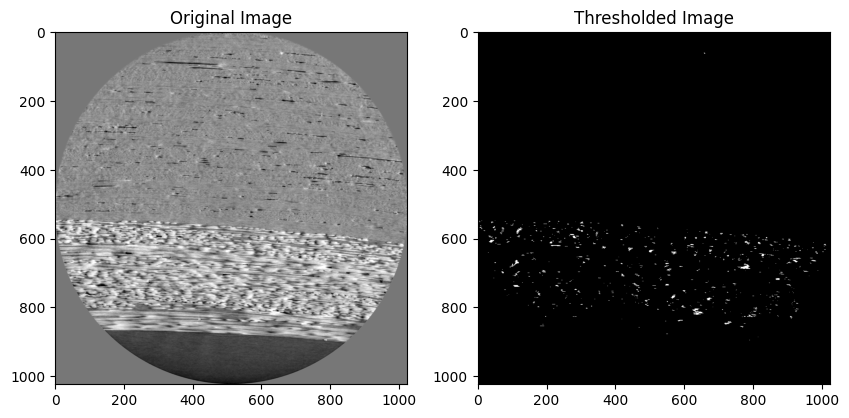

In [22]:
tmp = simple_thresholding(img, thresh_value=240, plot=True)

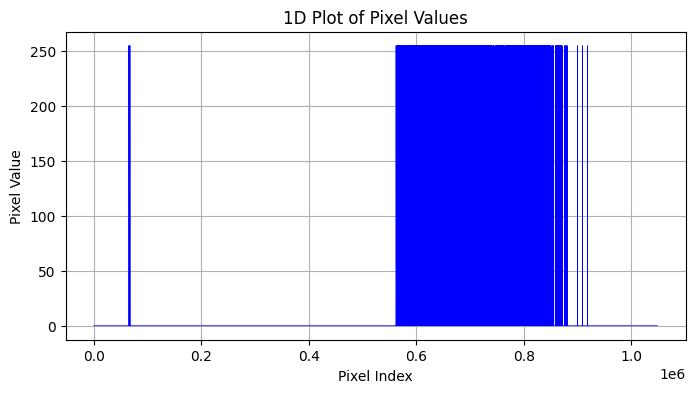

In [23]:
# Get the dimensions of the image
import itertools
height, width = tmp.shape

# Initialize an empty 1D list to store pixel values
pixel_values = []

locations = []
# Iterate through each pixel and append its value to the list
for y, x in itertools.product(range(height), range(width)):
    pixel_value = tmp[y, x]
    pixel_values.append(pixel_value)

    if pixel_value > 210:
        locations.append((y, x))

# Create a 1D plot of pixel values
plt.figure(figsize=(8, 4))
plt.plot(pixel_values, color='b', linewidth=0.5)
plt.title("1D Plot of Pixel Values")
plt.xlabel("Pixel Index")
plt.ylabel("Pixel Value")
plt.grid(True)
plt.show()

In [24]:
# Initialize variables
neighbor_pairs = []  # List to store neighbor pairs
current_pair = []  # Temporarily store neighbor pairs
previous_pair = None

# Iterate through the list of pairs
for pair in locations:
    if previous_pair is None:
        current_pair.append(pair)
    elif (pair[0] == previous_pair[0] and pair[1] == previous_pair[1] + 1) or \
         (pair[0] == previous_pair[0] + 1 and pair[1] == previous_pair[1]):
        current_pair.append(pair)
    else:
        neighbor_pairs.append(current_pair)
        current_pair = [pair]

    previous_pair = pair

# Add the last set of neighbor pairs
if current_pair:
    neighbor_pairs.append(current_pair)

In [25]:
reduced_neighbor_pairs = [ lst for lst in neighbor_pairs if len(lst) > 1 ]

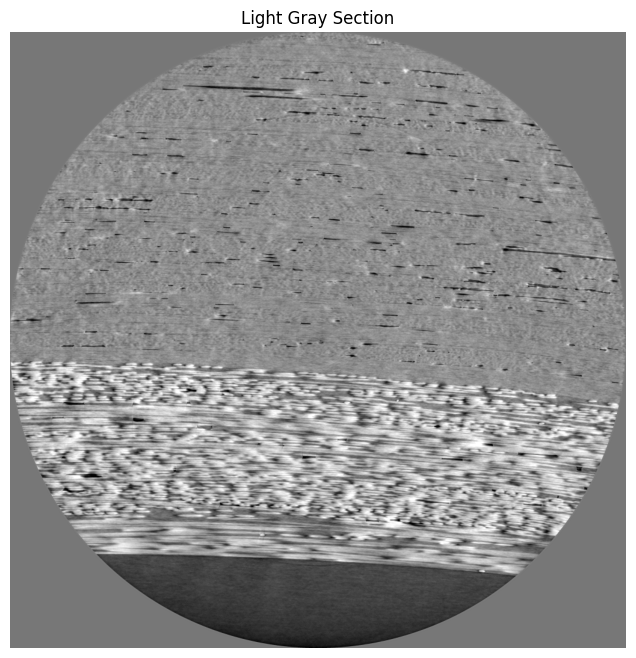

In [36]:
# Initialize cutoff location
cutoff_location = 2600, 0

# Iterate through reduced_neighbor_pairs to find the cutoff location
for lst in reduced_neighbor_pairs:
    for pair in lst:
        y, x = pair
        if y > 2500:
            cutoff_location = pair
            break
    if cutoff_location:
        break

# Check if a cutoff location is found
if cutoff_location:
    cutoff_row, _ = cutoff_location
    cropped_image = img[:cutoff_row, :]
else:
    print("No non-zero pixel found in the thresholded image.")
    cropped_image = img  # Default to the entire image

# Plot the resulting image using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(cropped_image, cmap='gray')
plt.title("Light Gray Section")
plt.axis('off')
plt.show()

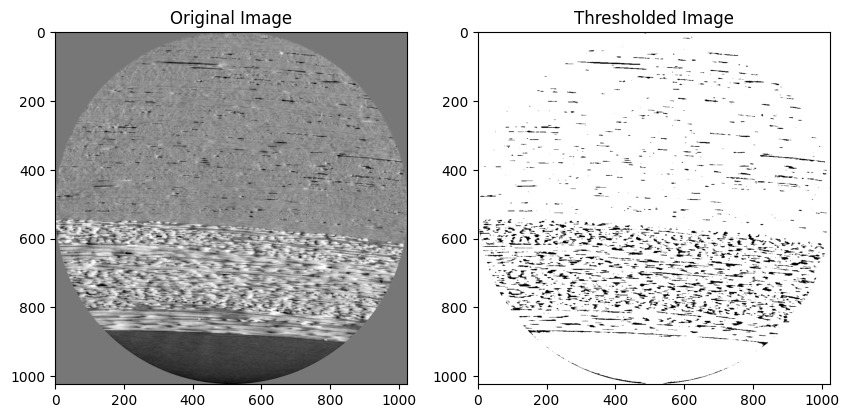

In [27]:
tmp = adaptive_thresholding(cropped_image, block_size=33, constant_offset=43, plot=True)

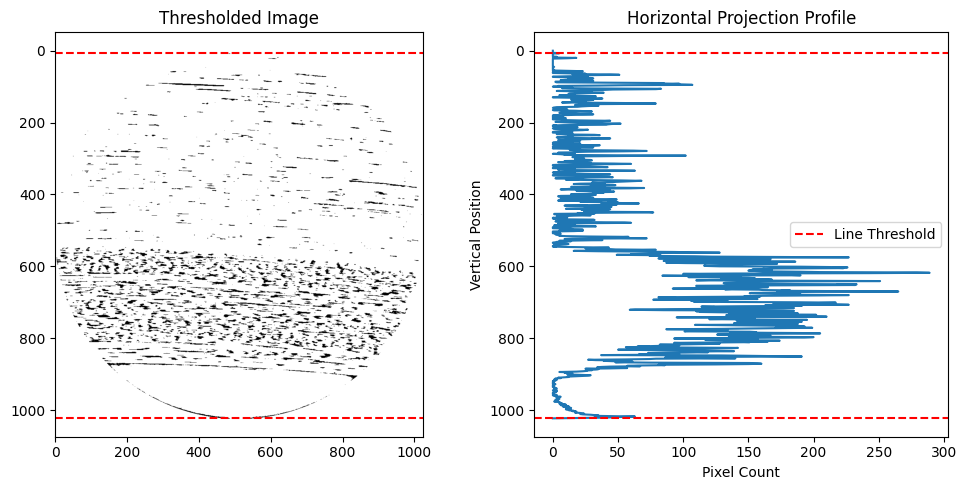

Line Lengths: [2, 2, 2, 1, 1, 3, 9, 26, 28, 28, 5, 14, 2, 1, 2, 16, 1, 5, 9, 27, 4, 5, 3, 14, 30, 5, 11, 6, 117, 1, 23, 8, 25, 7, 1, 373, 1, 1, 2, 1, 8, 5, 1, 2, 63]


In [28]:
# Define the line color (assumes lines are black on a white background)
line_color = 0  # Adjust this value if lines are white

# Create a horizontal projection profile
horizontal_projection = np.sum(tmp == line_color, axis=1)

# Calculate line positions
line_indices = np.where(horizontal_projection > 0)

# Plot the horizontal projection profile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First subplot (original image)
ax1.imshow(tmp, cmap='gray')
ax1.axhline(y=line_indices[0][0], color='r', linestyle='--')
ax1.axhline(y=line_indices[0][-1], color='r', linestyle='--')
ax1.set_title("Thresholded Image")

# Second subplot (horizontal projection profile)
ax2.plot(horizontal_projection, range(tmp.shape[0]))
ax2.axhline(y=line_indices[0][0], color='r', linestyle='--', label="Line Threshold")
ax2.axhline(y=line_indices[0][-1], color='r', linestyle='--')
ax2.set_title("Horizontal Projection Profile")
ax2.set_xlabel("Pixel Count")
ax2.set_ylabel("Vertical Position")
ax2.legend()

# Invert the y-axis for both subplots
ax1.invert_yaxis()
ax2.invert_yaxis()

# Share the same y-axis limits between subplots
ax1.set_ylim(ax2.get_ylim())

plt.tight_layout()
plt.show()

# Measure the lengths of line regions
line_lengths = []
current_length = 0

for pixel in horizontal_projection:
    if pixel > 0:  # Assuming line pixels are non-zero
        current_length += 1
    elif current_length > 0:
        line_lengths.append(current_length)
        current_length = 0
# Display the line lengths
print("Line Lengths:", line_lengths)

In [29]:
inverted_img = cv2.bitwise_not(tmp)

In [30]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inverted_img, connectivity=8)


In [31]:
min_area_threshold = 100  # Adjust as needed
line_mask = np.where(stats[1:, cv2.CC_STAT_AREA] >= min_area_threshold, 255, 0).astype(np.uint8)


In [32]:
contours, _ = cv2.findContours(inverted_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

1799

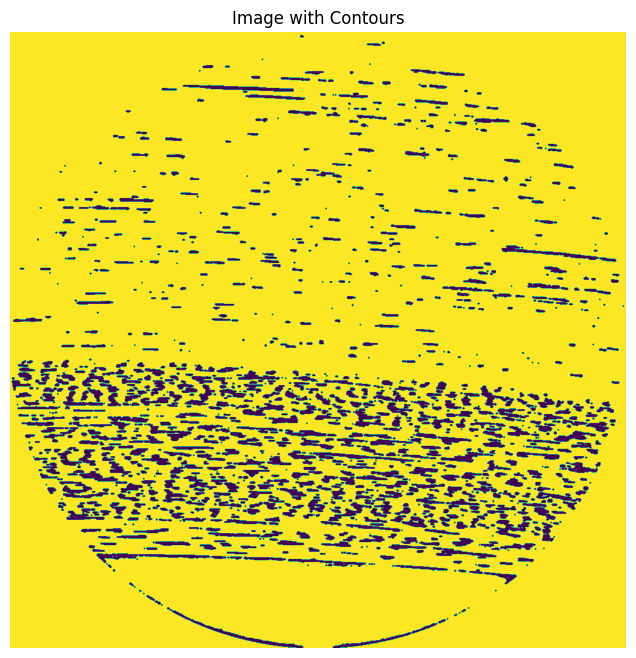

In [33]:
# Create a copy of the original image for visualization
original_image_copy = tmp.copy()

# Draw contours on the copy of the original image
cv2.drawContours(original_image_copy, contours, -1, (0, 0, 255), 2)  # Red color, line width = 2

# Display the image with contours
plt.figure(figsize=(8, 8))
plt.imshow(original_image_copy)
plt.title("Image with Contours")
plt.axis('off')
plt.show()

In [19]:
# Determine the original dimensions of your 4K monitor
monitor_width = 3840  # 4K resolution width

for i in range(num_labels):

    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]

    # Initialize text
    text = f"examining component {i + 1}/{num_labels}, with area: {area}"

    # Print a status message update for the current connected component
    print(f"[INFO] {text}")

    # Clone our original image (so we can draw on it) and then draw
    # a bounding box surrounding the connected component along with
    # a circle corresponding to the centroid
    output = cv2.cvtColor(tmp, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)

    # Construct a mask for the current connected component by
    # finding pixels in the labels array that have the current
    # connected component ID
    componentMask = (labels == i).astype("uint8") * 255

    # Calculate the new width for both images (half of the monitor width)
    new_width = monitor_width // 2

    # Resize the images while maintaining the aspect ratio
    output = cv2.resize(output, (new_width, int(output.shape[0] * (new_width / output.shape[1]))))
    componentMask = cv2.resize(componentMask, (new_width, int(componentMask.shape[0] * (new_width / componentMask.shape[1]))))

    # Show the output image and connected component mask
    cv2.imshow("Resized Output", output)
    cv2.imshow("Resized Connected Component", componentMask)
    cv2.waitKey(0)

# Close OpenCV windows
cv2.destroyAllWindows()


[INFO] examining component 1/549
[INFO] examining component 2/549
[INFO] examining component 3/549
[INFO] examining component 4/549
[INFO] examining component 5/549
[INFO] examining component 6/549
[INFO] examining component 7/549
[INFO] examining component 8/549
[INFO] examining component 9/549
[INFO] examining component 10/549
[INFO] examining component 11/549
[INFO] examining component 12/549
[INFO] examining component 13/549
[INFO] examining component 14/549
[INFO] examining component 15/549
[INFO] examining component 16/549
[INFO] examining component 17/549
[INFO] examining component 18/549
[INFO] examining component 19/549
[INFO] examining component 20/549
[INFO] examining component 21/549
[INFO] examining component 22/549
[INFO] examining component 23/549
[INFO] examining component 24/549
[INFO] examining component 25/549
[INFO] examining component 26/549
[INFO] examining component 27/549
[INFO] examining component 28/549
[INFO] examining component 29/549
[INFO] examining compon

In [ ]:
# for i in range(0, num_labels):
# 	# if this is the first component then we examine the
# 	# *background* (typically we would just ignore this
# 	# component in our loop)
# 	if i == 0:
# 		text = f"examining component {i + 1}/{num_labels} (background)"
# 	else:
# 		text = f"examining component {i + 1}/{num_labels}"
# 	# print a status message update for the current connected
# 	# component
# 	print(f"[INFO] {text}")
# 	# extract the connected component statistics and centroid for
# 	# the current label
# 	x = stats[i, cv2.CC_STAT_LEFT]
# 	y = stats[i, cv2.CC_STAT_TOP]
# 	w = stats[i, cv2.CC_STAT_WIDTH]
# 	h = stats[i, cv2.CC_STAT_HEIGHT]
# 	area = stats[i, cv2.CC_STAT_AREA]
# 	(cX, cY) = centroids[i]

# 	# clone our original image (so we can draw on it) and then draw
# 	# a bounding box surrounding the connected component along with
# 	# a circle corresponding to the centroid
# 	output = cv2.cvtColor(tmp, cv2.COLOR_GRAY2BGR)
# 	cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
# 	cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)

# 	# construct a mask for the current connected component by
# 	# finding a pixels in the labels array that have the current
# 	# connected component ID
# 	componentMask = (labels == i).astype("uint8") * 255
# 	# show our output image and connected component mask

# 	# Determine the original dimensions of your 4K monitor
# 	monitor_width = 3840  # 4K resolution width

# 	# Assuming `output` and `componentMask` are your images
# 	output_width, output_height = output.shape[1], output.shape[0]
# 	componentMask_width, componentMask_height = componentMask.shape[1], componentMask.shape[0]

# 	# Calculate the new width for both images (half of the monitor width)
# 	new_width = monitor_width // 2

# 	# Calculate the scaling factor for resizing
# 	output_scale = new_width / output_width
# 	componentMask_scale = new_width / componentMask_width

# 	# Resize the images while maintaining the aspect ratio
# 	output = cv2.resize(output, (new_width, int(output_height * output_scale)))
# 	componentMask = cv2.resize(componentMask, (new_width, int(componentMask_height * componentMask_scale)))

# 	# Display the resized images
# 	cv2.imshow("Resized Output", output)
# 	cv2.imshow("Resized Connected Component", componentMask)
# 	cv2.waitKey(0)

# 	cv2.destroyAllWindows()  # Close OpenCV windows


In [ ]:
# DATA = np.expand_dims(DATA, axis=1)

In [ ]:
# visualize_point_cloud(DATA[:500], thrs=[20,20,20,20], vis_tool="pyvista")